<a href="https://colab.research.google.com/github/BADS7604Group03/assignment2/blob/main/code/NASNetMobile_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* Add data augmentation in Network [done]
* Add Process save the best model, while training process [done]
* Load best model from file [done]
* Add Grad-CAM step [done]
* Add Accuracy by Class [done]
* Add ROC by Class [done]
* Unfreeze Last Layer



# Prepare the Environment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-695e7311-d3c5-9940-a8b2-0e10b4c7fc82)


In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"OpenCV {cv.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
NumPy 1.21.5
OpenCV 4.1.2
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
#Set seed value for reproducability during experiments Skilp this cell if random initialization (with varied result) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# Prepare training data

Prepare data by https://github.com/BADS7604Group03/assignment2/blob/main/code/Image_preprocessing.ipynb

## Load Data

In [ ]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/GroupAssignment02-PictureHashtag/data"

x_image = np.load(path+"/x_image_224_224.npy" )
y_image = np.load(path+"/y_image.npy"  )
class_dict = {i:nam for i,nam in enumerate(np.load(path+"/class_seq.npy" ))}

In [ ]:
num_class,num_member = np.unique(y_image, return_counts=True)
{'class':[class_dict[i] for i in num_class] 
,'Image':num_member}


{'Image': array([200, 200, 200]), 'class': ['atmosphere', 'food', 'menu']}

## Split data to Train and test

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x_image, y_image, test_size=0.20, random_state=1234)

print( f"x_train.shape={x_train.shape}, x_train.dtype={x_train.dtype}, min(x_train)={np.min(x_train):.4f} ,max(x_train)={np.max(x_train):.4f}")
print( f"x_test.shape={x_test.shape}, x_test.dtype={x_test.dtype}, min(x_test)={np.min(x_test):.4f} ,max(x_test)={np.max(x_test):.4f}\n")
print( f"y_train.shape={y_train.shape}, y_train.dtype={y_train.dtype}, min(y_train)={np.min(y_train):.4f} ,max(y_train)={np.max(y_train):.4f}")
print( f"y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}, min(y_test)={np.min(y_test):.4f} ,max(y_test)={np.max(y_test):.4f}")

x_train.shape=(480, 224, 224, 3), x_train.dtype=float32, min(x_train)=0.0000 ,max(x_train)=255.0000
x_test.shape=(120, 224, 224, 3), x_test.dtype=float32, min(x_test)=0.0000 ,max(x_test)=255.0000

y_train.shape=(480,), y_train.dtype=float64, min(y_train)=0.0000 ,max(y_train)=2.0000
y_test.shape=(120,), y_test.dtype=float64, min(y_test)=0.0000 ,max(y_test)=2.0000


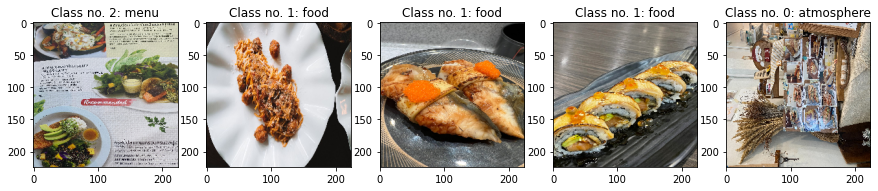

In [ ]:
#Visulize the first image in x_train
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(150+1+i).set_title(f"Class no. {int(y_train[i])}: {class_dict[int(y_train[i])]}")
  plt.imshow( x_train[i].astype(np.uint8))
plt.show()

## Preprocess data for NASNetMobile

In [ ]:
# Preprocess dataset to match NASNetMobile's requirement
x_train_nasnet = tf.keras.applications.nasnet.preprocess_input(x_train.copy())
x_test_nasnet =tf.keras.applications.nasnet.preprocess_input(x_test.copy())

print( f"x_train_nasnet shape={x_train_nasnet.shape}, dtype={x_train_nasnet.dtype}, min={np.min(x_train_nasnet):.4f} ,max={np.max(x_train_nasnet):.4f}")
print( f"x_test_nasnet shape={x_test_nasnet.shape}, dtype={x_test_nasnet.dtype}, min={np.min(x_test_nasnet):.4f} ,max={np.max(x_test_nasnet):.4f}")

x_train_nasnet shape=(480, 224, 224, 3), dtype=float32, min=-1.0000 ,max=1.0000
x_test_nasnet shape=(120, 224, 224, 3), dtype=float32, min=-1.0000 ,max=1.0000


# Prepare Model (use feature extractor from pretrained model)

## Load the pretrained model (Only Feature extractor)

In [ ]:
nasnet_extractor = tf.keras.applications.NASNetMobile(weights="imagenet", include_top=False)

#Freeze weights all layers in the model
nasnet_extractor.trainable = False

print(f"model input shape : {nasnet_extractor.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(nasnet_extractor.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in nasnet_extractor.layers])}")
nasnet_extractor.summary()

In [ ]:
#Print Layer detail
for i,j_layer in enumerate(nasnet_extractor.layers):
  print(f"Layer {i} {j_layer}: name = {j_layer.name}, trainable = {j_layer.trainable}")

## Add Classification Layers and set output for explore

In [ ]:
m = nasnet_extractor.output

#Add our custom layers to the end of the existing model 
m = tf.keras.layers.Flatten()(m)
m = tf.keras.layers.Dense(256 ,activation='relu')(m)
m = tf.keras.layers.Dense(512 ,activation='relu')(m)
m = tf.keras.layers.Dense(256 ,activation='relu')(m)
m = tf.keras.layers.Dropout(0.5)(m)
new_output = tf.keras.layers.Dense(len(class_dict), activation='softmax')(m)

# Construct the main model
model = tf.keras.models.Model(inputs=nasnet_extractor.input, outputs=new_output)

print(f"model input shape : {model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(model.layers)} \nTotal Parameter : {model.count_params():,.0f}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in model.layers])}")
print(f"Total Train Parameter : {np.sum([l.count_params() for l in model.layers if l.trainable == True]):,.0f}")

#model.summary()

model input shape : (None, 224, 224, 3)
Total Layer in Model : 775
Total Training Layer : 6


## Data Augmentation

In [ ]:
#Create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)
train_datagen.fit(x_train_nasnet)

===== Train batch no. 1/3 =====


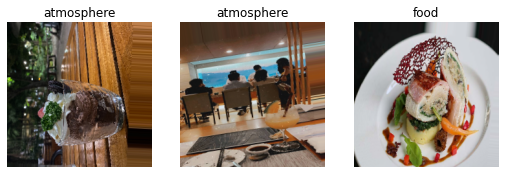

===== Train batch no. 2/3 =====


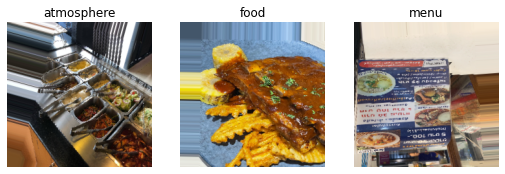

===== Train batch no. 3/3 =====


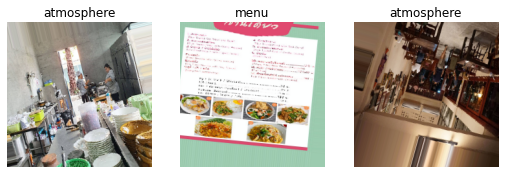

In [ ]:
from IPython.core.pylabtools import figsize
# Visualize some Training Image from the ImageDataGenerator
img_shape = x_train_nasnet.shape[1:]
n_show = 3
for b, (x_batch, y_batch) in enumerate( train_datagen.flow(x_train, y_train, batch_size=n_show ,subset='training')):
  print(f"{'='*5} Train batch no. {b+1}/{n_show} {'='*5}")
  plt.figure(figsize=(15,5))
  for i in range(n_show):
    plt.subplot(150+1+i).set_title(class_dict[int(y_batch[i])])
    plt.imshow(x_batch[i].astype(np.uint8).reshape(img_shape) , cmap='gray')
    plt.axis('off') #Remove all tick marks
  plt.show()
  if b+1 >= n_show:
    break

# Training Model with Transfer Learning

In [ ]:
#Check Save path and cleaning  
save_path = "./bestModel/"
if os.path.isdir(save_path):
  os.system(f"rm {save_path}*.hdf5")
else :
  os.system(f"mkdir {save_path}")

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
checkpoint_filepath = "bestModel/bestmodel_loss{val_loss:.2f}_epoch{epoch:02d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                               save_weights_only=False, 
                                                               monitor='val_acc', 
                                                               model='max', 
                                                               save_best_only=True)

In [ ]:
%%time
history = model.fit(train_datagen.flow( x_train_nasnet, y_train, batch_size=128, subset='training'), 
                          batch_size=128, epochs=50, verbose=1, 
                          validation_data=train_datagen.flow(x_train_nasnet, y_train, subset='validation'),
                          callbacks=[model_checkpoint_callback])

Epoch 1/50
3/3 [==============================] - 29s 4s/step - loss: 6.2283 - acc: 0.3724 - val_loss: 6.0150 - val_acc: 0.3333
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 5.1286 - acc: 0.5495 - val_loss: 1.3676 - val_acc: 0.7917
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 1.3539 - acc: 0.8307 - val_loss: 0.8188 - val_acc: 0.8958
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.7024 - acc: 0.9141 - val_loss: 0.5388 - val_acc: 0.9062
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 0.4736 - acc: 0.9297 - val_loss: 0.4040 - val_acc: 0.9271
Epoch 6/50
3/3 [==============================] - 6s 2s/step - loss: 0.4681 - acc: 0.9193 - val_loss: 0.4976 - val_acc: 0.9375
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 0.3736 - acc: 0.9557 - val_loss: 0.6617 - val_acc: 0.9167
Epoch 8/50
3/3 [==============================] - 5s 2s/step - loss: 0.2783 - acc: 0.9479 - val_loss: 0.5929 -

## Training Result

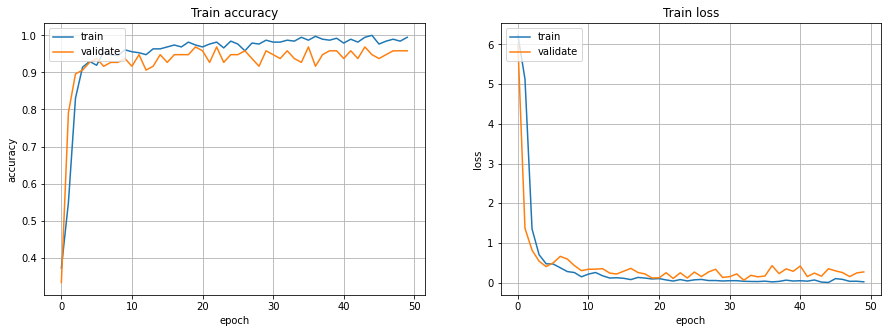

In [ ]:
#Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss');plt.ylabel('loss');plt.xlabel('epoch');plt.legend(['train', 'validate'] ,loc='upper left')
plt.grid()

plt.show()

## Get Best Model From file and Save best model to google drive

In [ ]:
#Get model best loss from file
best_loss = np.sort(np.array(os.listdir(save_path)))[0]
print(best_loss)

bestmodel_loss0.12_epoch20.hdf5


In [ ]:
#Save file best model to google drive
from_path = f"{save_path}{best_loss}"
to_path = f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/GroupAssignment02-PictureHashtag/modelFile/nasnet_freeze_{best_loss[10:]}"
print(f"from : {from_path}")
print(f"to : {to_path}")
os.system(f"cp '{from_path}' '{to_path}'")

from : ./bestModel/bestmodel_loss0.12_epoch20.hdf5
to : /content/drive/MyDrive/Colab Notebooks/BADS7604_DL/GroupAssignment02-PictureHashtag/modelFile/nasnet_freeze_loss0.12_epoch20.hdf5


0

In [ ]:
# Load Best Model from file
best_model = tf.keras.models.load_model(save_path+best_loss ,compile=True)
print(f"Model from file : {save_path}{best_loss}")
print(f"model input shape : {best_model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(best_model.layers)} \nTotal Parameter : {best_model.count_params():,.0f}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in best_model.layers])}")
print(f"Total Train Parameter : {np.sum([l.count_params() for l in best_model.layers if l.trainable == True]):,.0f}")

Model from file : ./bestModel/bestmodel_loss0.12_epoch20.hdf5
model input shape : (None, 224, 224, 3)
Total Layer in Model : 775 
Total Parameter : 17,780,119
Total Training Layer : 7
Total Train Parameter : 13,510,403


# Evaluation

In [ ]:
results = best_model.evaluate(x_test_nasnet, y_test ,batch_size = 64)
print(f"{best_model.metrics_names} = {results}")

2/2 [==============================] - 4s 176ms/step - loss: 0.2216 - acc: 0.9333
['loss', 'acc'] = [0.22164300084114075, 0.9333333373069763]


In [ ]:
def confusionPlot(model ,x,y_true,classSeq):
  import seaborn as sns
  from sklearn import metrics

  y_pred = np.argmax(model.predict(x), axis=1)
  cf_matrix = metrics.confusion_matrix(y_true, y_pred)

  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values')

  ax.xaxis.set_ticklabels(classSeq)
  ax.yaxis.set_ticklabels(classSeq)
  plt.show()
  return cf_matrix

def roc_auc(model,x_feature,y_true,classSeq):
  from sklearn.metrics import roc_curve, auc, roc_auc_score
  from sklearn.preprocessing import LabelBinarizer
  y_prob = model.predict(x_feature)
  y_label = LabelBinarizer().fit_transform(y_test)
  class_auc = []
  plt.figure(figsize=(15,5))
  for c,nam in enumerate(classSeq):
    fpr, tpr, thresholds = roc_curve(y_label[:,c], y_prob[:,c])
    class_auc.append(auc(fpr, tpr))
    plt.plot(fpr, tpr, label = f"{nam} (AUC:{class_auc[c]:0.4f})")
  
  roc_score = roc_auc_score(y_label, y_prob, average="macro")
  plt.legend()
  plt.title(f"ROC = {roc_score:0.4f}")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  return roc_score,class_auc

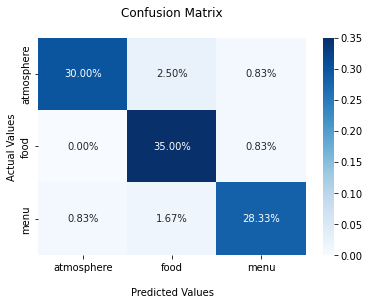

[[36  3  1]
 [ 0 42  1]
 [ 1  2 34]]


In [ ]:
cf_matrix = confusionPlot(best_model, x_test_nasnet, y_test, class_dict.values())
for i in range(3):
  print(f"{class_dict[i]} : {cf_matrix[i,i]/cf_matrix[i,:].sum()}")
print(f"Total Accuracy : {cf_matrix.diagonal().sum()/cf_matrix.sum()}")

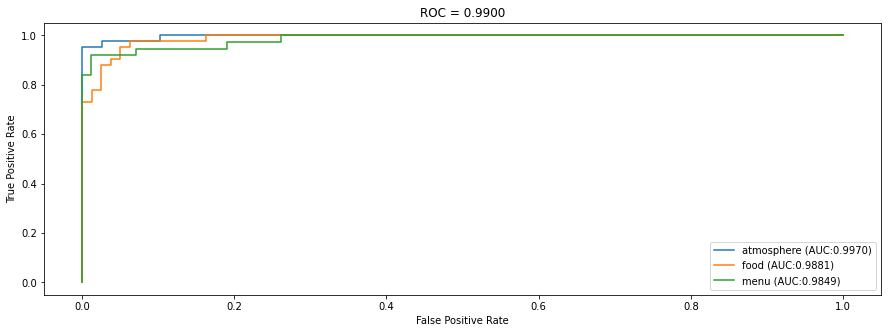

In [ ]:
roc_score,lst_auc = roc_auc(best_model,x_test_nasnet,y_test, class_dict.values())
print(f"roc_score : {roc_score}")
for i in range(3):
  print(f"{class_dict[i]} : {lst_auc[i]}")

# Inference

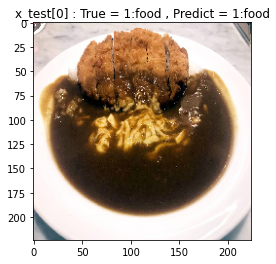

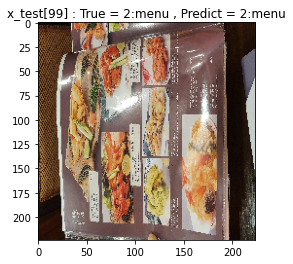

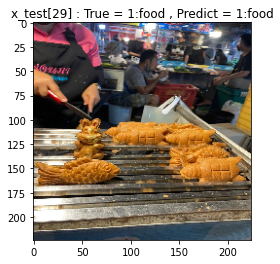

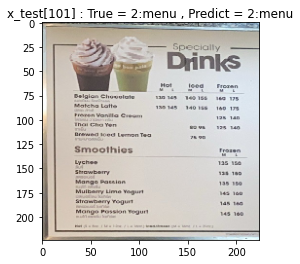

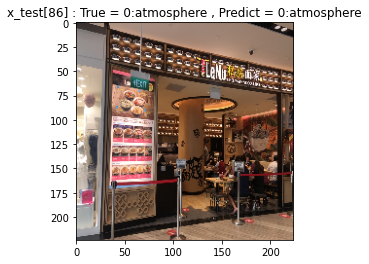

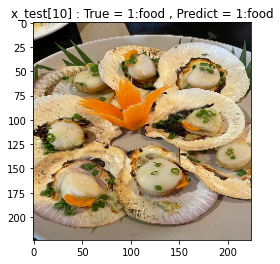

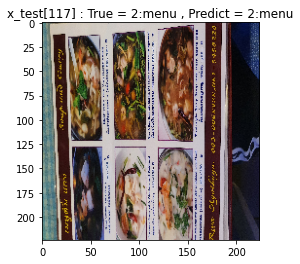

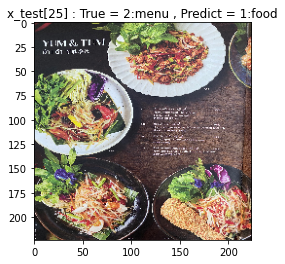

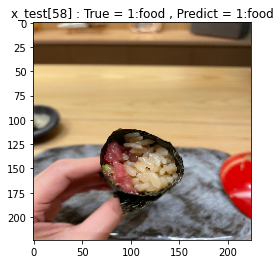

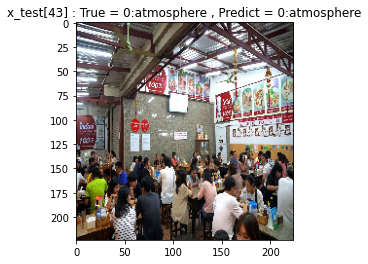

In [ ]:
#test ussing the model on the first 10 image in x_test
for i in np.random.choice(x_test_nasnet.shape[0] ,10):
  y_pred = best_model.predict(x_test_nasnet[i].reshape(1,224, 224, 3))

  plt.imshow( x_test[i].astype(np.uint8))
  plt.title(f"x_test[{i}] : True = {int(y_test[i])}:{class_dict[int(y_test[i])]} , Predict = {np.argmax(y_pred)}:{class_dict[np.argmax(y_pred)]}")
  plt.show()


# Debug Model

## Fix Output Layer and Get weight in Last Convolutional Layer

In [ ]:
def alter_model_for_GradCAM(model, last_conv_layer_name):
  #1) Get the output from the last convolutional layer
  last_conv_output = model.get_layer(last_conv_layer_name).output

  #2) Separate the original output layer into one prediction layer and one activation softmax layer
  ### 2.1) Copy weight of the original output layers
  old_weights = [x.numpy() for x in model.layers[-1].weights]
  ### 2.2) Copy configuration of the original layer and change where necessary
  new_config = model.layers[-1].get_config()
  new_config['activation'] = tf.keras.activations.linear    #layer's activation changed
  new_config['name'] = 'pred_linear'                           #layer's name changed
  ### 2.3 Create two new layers (linear prediction and softmax)
  out_linear = tf.keras.layers.Dense(**new_config)(model.layers[-2].output)
  out_softmax = tf.keras.activations.softmax(out_linear)

  #3) Create the new model and assign the weight for the 'prediction_linear' layer
  new_model = tf.keras.Model(inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output])
  new_model.layers[-2].set_weights(old_weights) # Assign old weight pred_linear layer 

  return new_model

In [ ]:
new_model = alter_model_for_GradCAM(best_model, 'activation_187')

print(f"model input shape : {new_model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(new_model.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in new_model.layers])}")
print(f"Input layer : {new_model.input_names}")
print(f"Output layer: {new_model.output_names}")

model input shape : (None, 224, 224, 3)
Total Layer in Model : 776
Total Training Layer : 8
Input layer : ['input_1']
Output layer: ['tf.nn.softmax', 'pred_linear', 'activation_187']


In [ ]:
#Test Prediction 
img_index = np.random.choice(x_test_nasnet.shape[0] ,1)
img_test = x_test_nasnet[img_index].reshape(-1,224, 224, 3)
img_test_ori = x_test[img_index][0]
out_softmax,out_liner,_ = new_model.predict(img_test)

## Decode Predictions

In [ ]:
def decode_prediction(preds,classDict,top_class=3):
  if preds.shape[1] != len(classDict):
    raise ValueError("Predictino and Class dict doesn't match")
  results = []
  indexs = []
  for pred in preds:
    top_indices = pred.argsort()[-top_class:][::-1]
    result = [ (i,) + (classDict[i],)+ (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[-1], reverse=True)
    indexs.append([tp[0] for tp in result ])
    results.append(result)

  return results, indexs

In [ ]:
tops = 3
result_decodes,result_indexs = decode_prediction(out_softmax, class_dict, tops)
print(f"Result of decode \n {result_decodes}")
print(f"Result of index \n {result_indexs}")

Result of decode 
 [[(2, 'menu', 0.99992466), (1, 'food', 7.4475516e-05), (0, 'atmosphere', 8.1750034e-07)]]
Result of index 
 [[2, 1, 0]]


## GradCAM Heatmap

In [ ]:
def CNN_GradCAM(model,x_input,c):
  in_img = tf.cast(x_input ,tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_softmax, y_linear, last_conv_activation = model(in_img)
    one_class_score = y_linear[...,c]
  gradient = tape.gradient( one_class_score, last_conv_activation) 
  
  gradient = gradient.numpy().squeeze(axis=0)
  alpha = np.mean(gradient ,axis=(0,1)) 
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)
  heatmap = np.dot(last_conv_activation,alpha)
  heatmap = np.maximum(0 ,heatmap)

  return heatmap

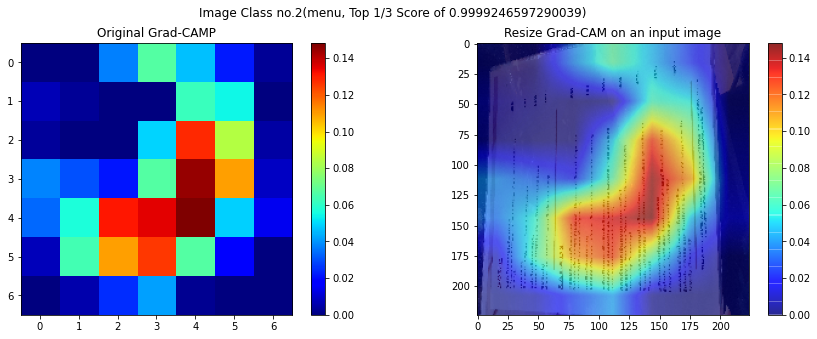

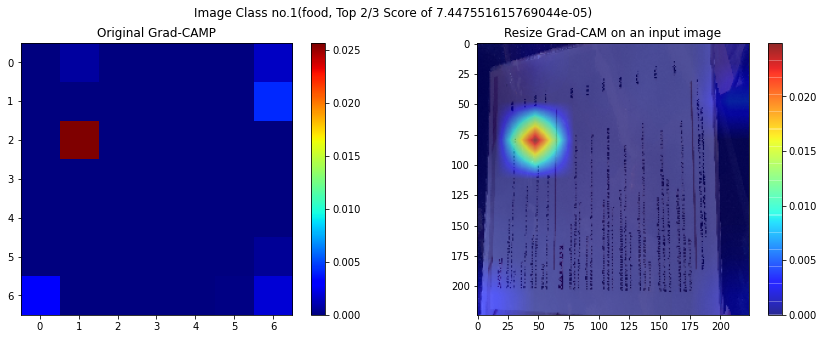

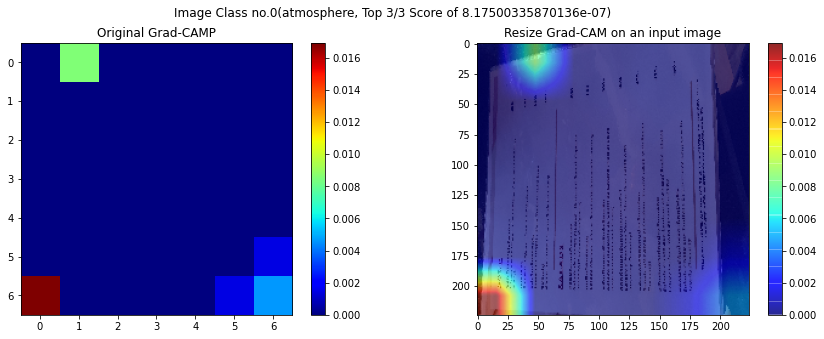

In [ ]:
for i,c in enumerate(result_indexs[0]):
  heatmap = CNN_GradCAM(new_model,  img_test, c )
  #Create the main figure
  fig = plt.figure(figsize=(15,5))
  class_desc = f"{class_dict[c]}, Top {i+1}/{tops} Score of {out_softmax[...,c].squeeze()}"
  fig.suptitle(f"Image Class no.{c}({class_desc})")
  # Visualize the Original Heatmap
  ax = fig.add_subplot(1,2,1)
  ax.set_title('Original Grad-CAMP')
  im = ax.imshow( heatmap ,cmap='jet')
  plt.colorbar(im, ax=ax)

  #Visualize the heatmap overlaid on an input image
  ax = fig.add_subplot(1,2,2)
  ax.set_title('Resize Grad-CAM on an input image')
  ax.imshow(img_test_ori.astype(np.uint8))
  alpha = 0.6
  im = ax.imshow(cv.resize( heatmap, img_test_ori.shape[:2]), cmap='jet', alpha=alpha )
  plt.colorbar(im, ax=ax)

  plt.show()